Using device: cuda
Loading model: variational_autoencoder
Loading checkpoint: ../checkpoints/variational_autoencoder/variational_autoencoder_20251118_224229/final.pth


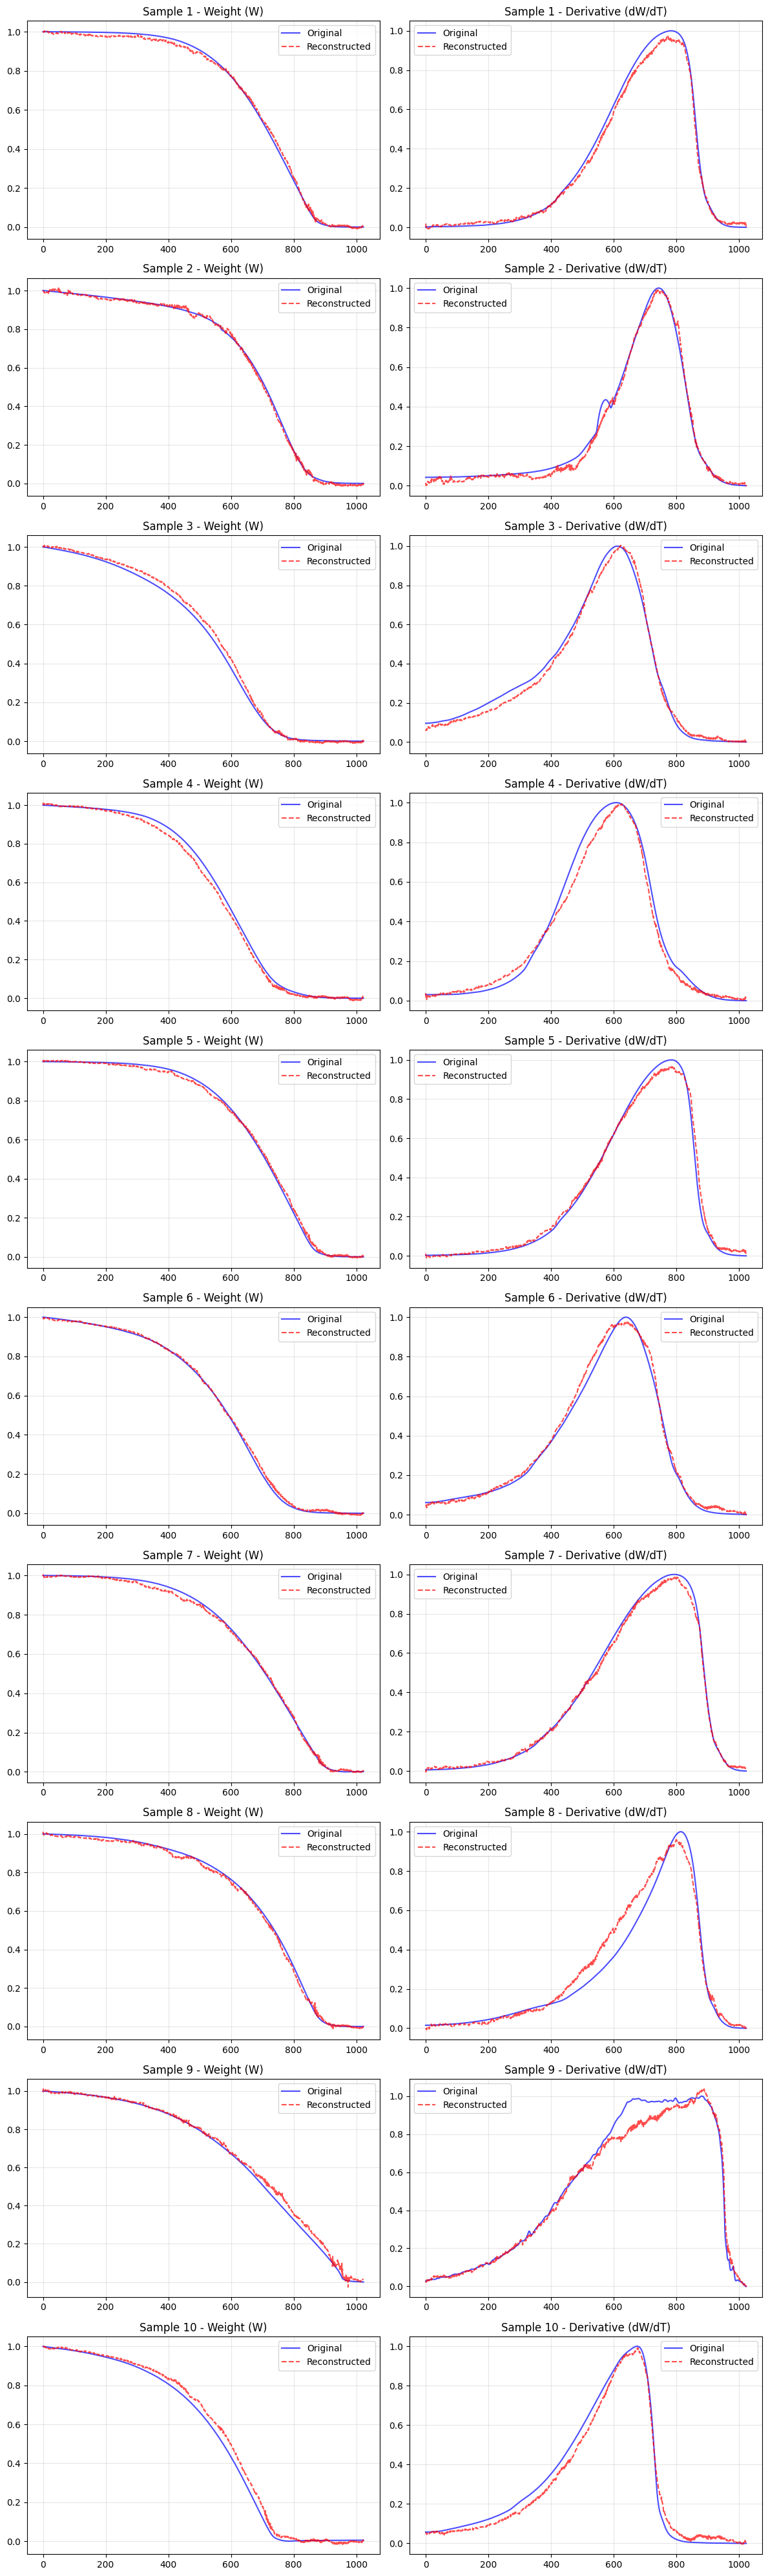

In [1]:
import torch
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.factory import get_model
from src.dataset import TGADataset
from torch.utils.data import DataLoader

data_path = '../data/tga/data.npz'
model_name = 'variational_autoencoder'
checkpoint_path = f'../checkpoints/{model_name}/variational_autoencoder_20251118_224229/final.pth'
num_samples = 10
latent_dim = 64
save_path = None

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load Dataset
# mode='reconstruction' returns (x, x)
dataset = TGADataset(data_path=data_path, mode='reconstruction')
dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

# Load Model
print(f"Loading model: {model_name}")
model = get_model(model_name, compressed_dim=latent_dim)

# Load Checkpoint
print(f"Loading checkpoint: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

# Handle different checkpoint saving formats (full dict vs just state_dict)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)
    
model.to(device)
model.double() # Ensure precision matches data (usually float64 in numpy)
model.eval()

# Get a batch of data
x, _ = next(iter(dataloader))
x = x.to(device)

# Forward pass
with torch.no_grad():
    output = model(x)
    
# Handle VAE output (recon, mu, logvar) or standard output
if isinstance(output, tuple):
    recon_x = output[0]
else:
    recon_x = output

# Move to CPU for plotting
x = x.cpu().numpy()
recon_x = recon_x.cpu().numpy()

# Plotting
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

# Handle case where num_samples=1 (axes is 1D array)
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Channel 0: Weight (W)
    axes[i, 0].plot(x[i, 0], label='Original', color='blue', alpha=0.7)
    axes[i, 0].plot(recon_x[i, 0], label='Reconstructed', color='red', linestyle='--', alpha=0.7)
    axes[i, 0].set_title(f'Sample {i+1} - Weight (W)')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)

    # Channel 1: Derivative (dW/dT)
    axes[i, 1].plot(x[i, 1], label='Original', color='blue', alpha=0.7)
    axes[i, 1].plot(recon_x[i, 1], label='Reconstructed', color='red', linestyle='--', alpha=0.7)
    axes[i, 1].set_title(f'Sample {i+1} - Derivative (dW/dT)')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()

if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")
else:
    plt.show()